In [2]:
""" Notebook looking at the merged sleep_position/o2 data
    Updates:
       Inferred ODI events before notebook
       Keep rows that were missing position measurements
       (Previously all rows had to be complete)
"""

import sys
sys.path.append('/Users/kmcmanus/Documents/classes/digitalhealth_project/digital_health_venv/lib/python3.7/site-packages')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit
from sklearn import preprocessing

import warnings
warnings.filterwarnings("ignore")



sns.set(style="ticks")
sns.set_context(context="talk")


In [3]:
# Read in data
infile = "/Users/kmcmanus/Documents/classes/digitalhealth_project/data/formatted_data/20200628_sleep_pos_5S_cleaned.csv"
df = pd.read_csv(infile, index_col='datetime', parse_dates=True, infer_datetime_format=True)
df["sleep_night"] = pd.to_datetime(df["sleep_night"])
df = df[(~df["Orientation"].isna() | ~df["SpO2(%)"].isna())]
print("Total # rows: {}".format(df.shape[0]))

Total # rows: 156424


In [4]:
df.describe()

,Orientation,Inclination,SpO2(%),Pulse Rate(bpm),Motion,Vibration,ODI,orient_bin,low_oxygen,hour,complete_hour,complete_night,time_since_pos_start
count,100827.000000,100827.000000,156424.000000,156424.000000,156424.000000,156424.000000,156411.000000,100827.000000,156424.000000,156424.000000,156424.000000,156424.000000,156424.000000
mean,-15.725180,92.354492,95.534912,62.027087,1.131246,0.085102,0.018739,0.138663,0.004462,9.291579,0.520125,0.975432,105.193359
std,73.536082,17.457866,1.842711,4.538416,7.261719,3.299377,0.135603,0.829362,0.066651,9.396579,0.499596,0.154804,154.062962
min,-179.630000,46.460000,71.000000,47.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,-79.740000,76.740000,95.000000,59.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,2.000000,0.000000,1.000000,1.000000
50%,-14.530000,95.150000,96.000000,61.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,1.000000,39.000000
75%,65.350000,106.130000,97.000000,65.000000,0.000000,0.000000,0.000000,1.000000,0.000000,21.000000,1.000000,1.000000,150.000000
max,179.510000,178.910000,99.000000,96.000000,148.000000,128.000000,1.000000,1.000000,1.000000,23.000000,1.000000,1.000000,1115.000000


In [5]:
# How many days I have measurements for at least sleep position or SpO2
dates = np.unique(df["sleep_night"])
dates = [pd.Timestamp(date) for date in dates]
print("Number of dates: {}".format(len(dates)))

Number of dates: 26


Text(0.5, 0, 'ODI (low oxygen) events')

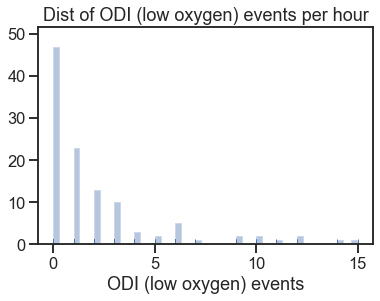

In [6]:
# Add 'block' column which signifies the entry to an ODI.
# Counting the number of 1s in 'block' is the number of low oxygen events
df_comp_hour = df[df["complete_hour"] == 1]
df_comp_hour.head()
# Counts number of times an ODI is entered
df_comp_hour["block"] = 0
#df_comp_hour["block"] = (
#                (df_comp_hour["ODI"] != df_comp_hour["ODI"].shift(1)) &
#                (df_comp_hour["ODI"] == 1)
#               ).astype(int).max()
df_comp_hour.loc[
    (df_comp_hour["ODI"] != df_comp_hour["ODI"].shift(1)) &
    (df_comp_hour["ODI"] == 1), "block"] = 1


df_low = df_comp_hour.groupby([df_comp_hour.index.date, df_comp_hour.index.hour]).sum()
ax = sns.distplot(df_low["block"], bins=45, kde=False, rug=True)
ax.set_title("Dist of ODI (low oxygen) events per hour")
ax.set_xlabel("ODI (low oxygen) events")

In [7]:
# Fit exponential dist to data
from scipy.optimize import curve_fit\

# define type of function to search
def model_func(x, a, k, b):
    return a * np.exp(-k*x) + b


#ok = pd.DataFrame(df_low['block'].value_counts())
ok = np.histogram(df_low['block'], bins=16)
print(ok[0])

[47 23 13 10  3  2  5  1  0  2  2  1  2  0  1  1]


16
16


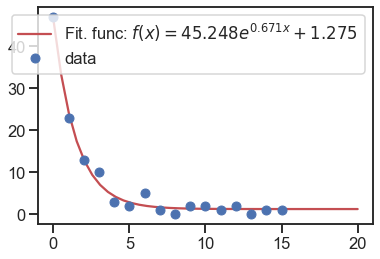

In [8]:
# Fit exponential dist to data
from scipy.optimize import curve_fit

# define type of function to search
def model_func(x, a, k, b):
    return a * np.exp(-k*x) + b

y = ok[0]
x = np.arange(0, 16)
print(len(x))
print(len(y))

# curve fit
p0 = (1.,1.e-5,1.) # starting search koefs
opt, pcov = curve_fit(model_func, x, y, p0)
a, k, b = opt
# test result
x2 = np.linspace(0, 20, 40)
y2 = model_func(x2, a, k, b)
fig, ax = plt.subplots()
ax.plot(x2, y2, color='r', label='Fit. func: $f(x) = %.3f e^{%.3f x} %+.3f$' % (a,k,b))
ax.plot(x, y, 'bo', label='data')
ax.legend(loc='best')
plt.show()

In [9]:
# Chi squared test for back vs. non-back with an ODI event
test_df = df[["ODI", "orient_bin"]].dropna()
test_df["orient_bin"] = abs(test_df["orient_bin"])
test_df["ODI"] = test_df["ODI"].astype(str)
test_df["orient_bin"] = test_df["orient_bin"].astype(str)
#ok = test_df[["ODI", "orient_bin"]].groupby(["ODI", "orient_bin"]).size()
ok = pd.crosstab(test_df["ODI"], test_df["orient_bin"]) 
#         back   not_back
# no_ODI
# ODI
print(ok)

# Significant!
from scipy.stats import chi2_contingency # Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(ok)
print(c)
print(p)
print(dof)
print(expected)

notback = 407/70877.0
back = 768/28771.0
print(notback)
print(back)
odds = back / notback
print("p-value: %i" % p)
print("Odds ratio: %s" %odds)

orient_bin    0.0    1.0
ODI                     
0.0         28771  70877
1.0           763    407
735.5953276658855
5.439216122598549e-162
1
[[29191.25584717 70456.74415283]
 [  342.74415283   827.25584717]]
0.005742342367763872
0.026693545584095094
p-value: 0
Odds ratio: 4.648546511950634


In [10]:
# Chi squared test for *entering* an ODI event on back vs. not-back
test_df = df_comp_hour[["block", "orient_bin"]].dropna()
test_df["orient_bin"] = abs(test_df["orient_bin"])
test_df["block"] = test_df["block"].astype(str)
test_df["orient_bin"] = test_df["orient_bin"].astype(str)
#ok = test_df[["ODI", "orient_bin"]].groupby(["ODI", "orient_bin"]).size()
ok = pd.crosstab(test_df["block"], test_df["orient_bin"]) 
#         back   not_back
# no_ODI
# ODI
print(ok)

# OK
from scipy.stats import chi2_contingency # Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(ok)
print(c)
print(p)
print(dof)
print(expected)

notback = 75/57206.0
back = 165/23914.0
print(notback)
print(back)
odds = back / notback
print("p-value: %i" % p)
print("Odds ratio: %s" %odds)

orient_bin    0.0    1.0
block                   
0           23914  57206
1             165     75
175.22406189156848
5.349060343698148e-40
1
[[24007.97050147 57112.02949853]
 [   71.02949853   168.97050147]]
0.0013110512883263994
0.0068997240110395585
p-value: 0
Odds ratio: 5.262741490340386


Text(0.5, 1.0, 'Sleep position when SpO2 < 92%')

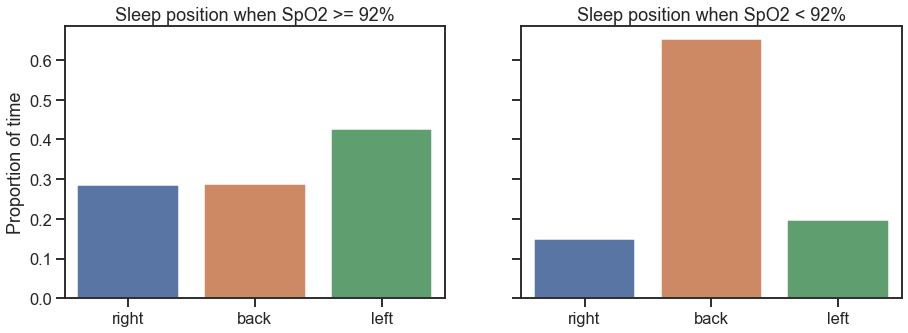

In [24]:
df["orient_bin"] = df["orient_bin"].astype(str)
df = df[df["orient_bin"] != "nan"]
df["side"] = "back"
df.loc[df["orient_bin"] == "-1.0", "side"] = "right"
df.loc[df["orient_bin"] == "1.0", "side"] = "left"
df_control = df[df["ODI"] == 0]

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
nrows = df_control.shape[0]
right = df_control[df_control["side"] == "right"].shape[0] / float(nrows)
back = df_control[df_control["side"] == "back"].shape[0] / float(nrows)
left = df_control[df_control["side"] == "left"].shape[0] / float(nrows)

sns.barplot(ax=axes[0], x=["right", "back", "left"], y=[right, back, left])
axes[0].set_title("Sleep position when SpO2 >= 92%")
axes[0].set_ylabel("Proportion of time")

df_odi = df[df["ODI"] == 1]
nrows = df_odi.shape[0]
right = df_odi[df_odi["side"] == "right"].shape[0] / float(nrows)
back = df_odi[df_odi["side"] == "back"].shape[0] / float(nrows)
left = df_odi[df_odi["side"] == "left"].shape[0] / float(nrows)

sns.barplot(ax=axes[1], x=["right", "back", "left"], y=[right, back, left])
axes[1].set_title("Sleep position when SpO2 < 92%")

Text(0.5, 1.0, 'Sleep position when SpO2 < 92%')

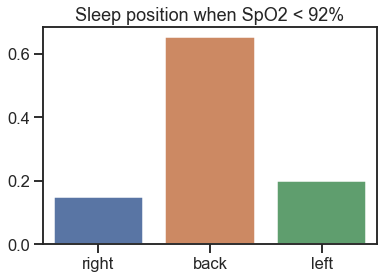

In [20]:
df_odi = df[df["ODI"] == 1]

nrows = df_odi.shape[0]
right = df_odi[df_odi["side"] == "right"].shape[0] / float(nrows)
back = df_odi[df_odi["side"] == "back"].shape[0] / float(nrows)
left = df_odi[df_odi["side"] == "left"].shape[0] / float(nrows)

sns.barplot(x=["right", "back", "left"], y=[right, back, left])
plt.title("Sleep position when SpO2 < 92%")

Text(0.5, 0, 'Number of low oxygen events (Only nights >= 5 hours)')

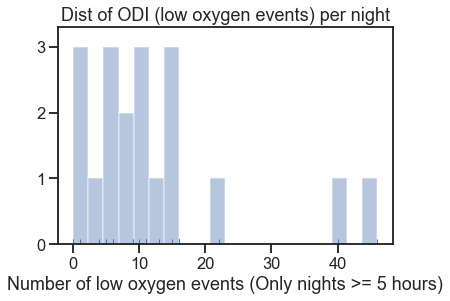

In [13]:
df_night = df_comp_hour[df_comp_hour["complete_night"] == 1]
df_night_to_plot = df_night.groupby("sleep_night")["block"].sum()

ax = sns.distplot(df_night_to_plot, bins=20, kde=False, rug=True)
ax.set_title("Dist of ODI (low oxygen events) per night")
ax.set_xlabel("Number of low oxygen events (Only nights >= 5 hours)")

In [14]:
df.columns

Index(['Orientation', 'Inclination', 'sleep_night', 'SpO2(%)',
       'Pulse Rate(bpm)', 'Motion', 'Vibration', 'ODI', 'orient_bin',
       'low_oxygen', 'hour', 'complete_hour', 'complete_night',
       'time_since_pos_start', 'side'],
      dtype='object')

In [15]:
# This doesn't take into account time edge cases
df["new_ODI"] = 0
df.loc[
    (df["ODI"] != df["ODI"].shift(1)) &
    (df["ODI"] == 1), "new_ODI"] = 1
df.columns

Index(['Orientation', 'Inclination', 'sleep_night', 'SpO2(%)',
       'Pulse Rate(bpm)', 'Motion', 'Vibration', 'ODI', 'orient_bin',
       'low_oxygen', 'hour', 'complete_hour', 'complete_night',
       'time_since_pos_start', 'side', 'new_ODI'],
      dtype='object')

ValueError: could not convert string to float: 'left'

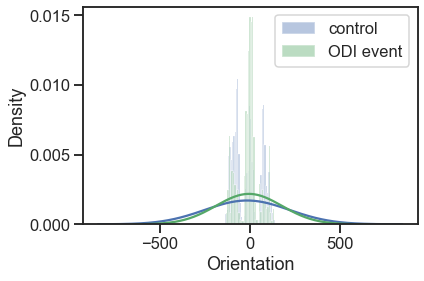

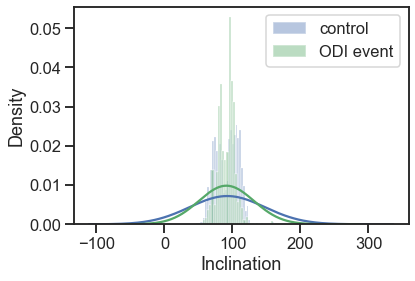

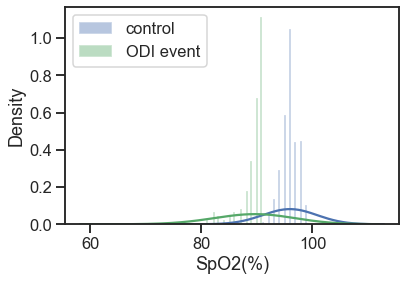

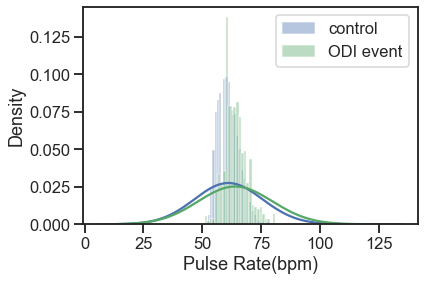

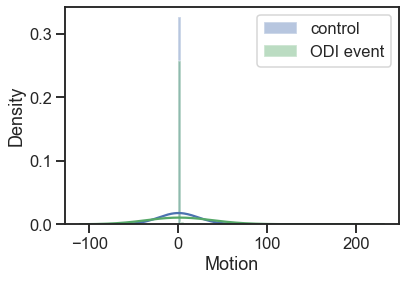

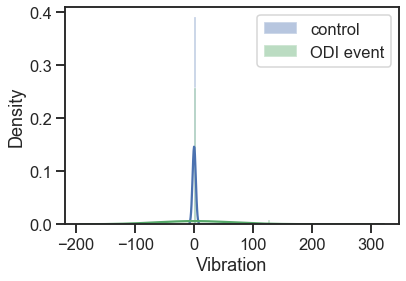

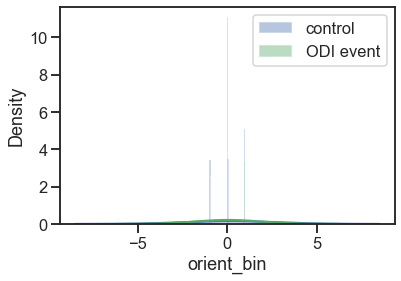

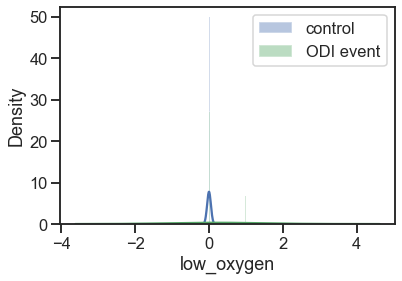

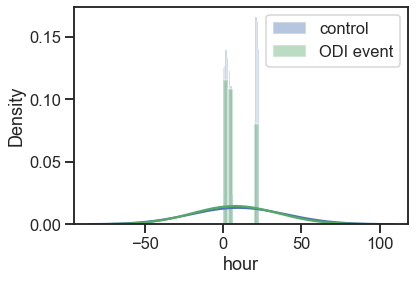

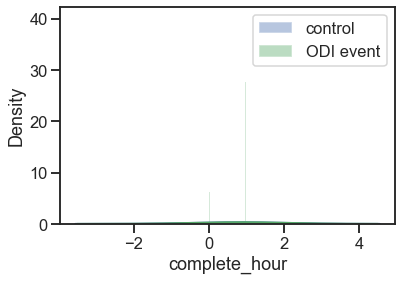

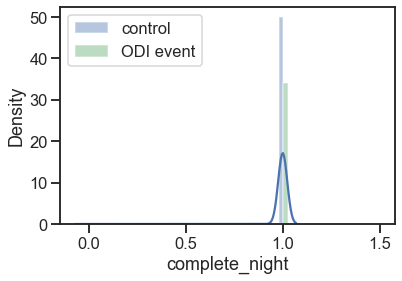

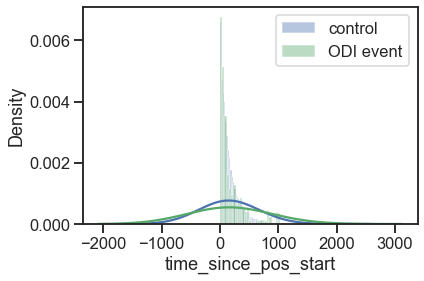

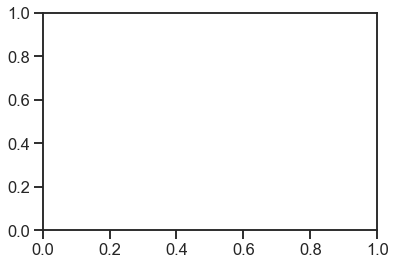

In [16]:
# Print feature distributions
features = df.columns

for feature in features:
    if feature == "sleep_night" or feature == "ODI":
        continue
    df_to_use = df[["ODI", feature]].dropna()
    
    fig, ax = plt.subplots()
    sns.distplot(df_to_use.loc[df_to_use["ODI"] == 0, feature],
                ax=ax, kde_kws={'bw': 3}, label="control")
    sns.distplot(df_to_use.loc[df_to_use["ODI"] == 1, feature],
                 ax=ax, color='g', kde_kws={'bw': 3}, label="ODI event")
    ax.legend()

In [ ]:

feature = "time_since_pos_start"

df_to_use = df[["ODI", "orient_bin", "time_since_pos_start"]].dropna()
df_to_use["ok"] = df_to_use["ODI"].astype(int).astype(str) + "_" + df_to_use["orient_bin"].astype(int).astype(str)
print(df_to_use["ok"].head())
    
fig, ax = plt.subplots()
sns.distplot(df_to_use.loc[df_to_use["ok"] == "0_1", feature],
            ax=ax, kde_kws={'bw': 3}, label="noODI_left")
sns.distplot(df_to_use.loc[df_to_use["ok"] == "0_0", feature],
            ax=ax, kde_kws={'bw': 3}, label="noODI_back")
sns.distplot(df_to_use.loc[df_to_use["ok"] == "0_-1", feature],
            ax=ax, kde_kws={'bw': 3}, label="noODI_right")
ax.legend()
fig, ax = plt.subplots()
sns.distplot(df_to_use.loc[df_to_use["ok"] == "1_1", feature],
            ax=ax, kde_kws={'bw': 3}, label="ODI_left")
sns.distplot(df_to_use.loc[df_to_use["ok"] == "1_0", feature],
            ax=ax, kde_kws={'bw': 3}, label="ODI_back")
sns.distplot(df_to_use.loc[df_to_use["ok"] == "1_-1", feature],
            ax=ax, kde_kws={'bw': 3}, label="ODI_right")
ax.legend()

In [ ]:
feats = np.array(df.columns)


test = pd.get_dummies(df['orient_bin'], prefix='orient')
df = pd.concat([df, test], axis=1)
df.head()

In [ ]:
# Logistic regression feature importance

# Everything except Orient_bin is significant lol.
# Try to make a graphical model out of this.

for i in np.array(df.columns):
    print(i)
    if i in ["sleep_night", "ODI", "orient_bin", "Orientation"]:
        continue
    df_to_use = df[["ODI", i]].dropna()
    x = preprocessing.scale(df_to_use[i]) # scaling features to mean 0, variance 1
    X = np.array(x).reshape(-1, 1) 
    logit_mod = sm.Logit(df_to_use["ODI"], X)
    result = logit_mod.fit(disp=0)
    print(result.summary())


In [ ]:
# Just try a random forest model to see how it works.
# It doesn't work well - low recall. Probably need to construct some better features.


from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

from IPython.display import SVG
from graphviz import Source
import graphviz
from IPython.display import display

df_nona = df.dropna()
#X = df_nona[['Inclination', 'Pulse Rate(bpm)', 'Motion',
#             'orient_-1.0', 'orient_0.0', 
#             'orient_1.0', 'hour', 'complete_hour', 'complete_night']] # Orientation, sleep_night
X = df_nona[['Pulse Rate(bpm)', 'orient_0.0']]
y = df_nona['low_oxygen']
#y = df_nona['ODI'] # or new_ODI or ODI or low_oxygen

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

clf = DecisionTreeClassifier(max_depth=10, random_state=0, class_weight='balanced')
clf.fit(X_train, y_train)

dot_data = tree.export_graphviz(clf,out_file=None,
         #                       feature_names=['Inclination', 'Pulse Rate(bpm)', 'Motion',
         #    'orient_-1.0', 'orient_0.0', 
         #    'orient_1.0', 'hour', 'complete_hour', 'complete_night'],
                                feature_names=['Pulse Rate(bpm)', 'orient_0.0'],
                                class_names=True,
                               filled=True)

display(graphviz.Source(dot_data))
#graph = graphviz.Source(dot_data)
#graph.render("image",view=True)


train_predict = clf.predict(X_train)
test_predict = clf.predict(X_test)

# returns: precision, recall, f_beta, support
result_train = precision_recall_fscore_support(y_train, train_predict) #, average='binary')
result_test = precision_recall_fscore_support(y_test, test_predict) #, average='binary')

print(result_train)
print("test")
print(result_test)

print(pd.Series(train_predict).value_counts())
print(pd.Series(test_predict).value_counts())

In [ ]:
# Permutation feature importances
from sklearn.inspection import permutation_importance

importances = permutation_importance(clf, X_test, y_test, n_repeats=5, random_state=0)

mean_imp = importances.importances_mean
indices = np.argsort(mean_imp)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], mean_imp[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), mean_imp[indices],
        color="r", yerr=importances.importances_std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()